In [29]:
ALGORITHM = 'KNN'
ALGORITHM_DETAIL = 'random search'
VERSION = '02'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

In [31]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    import functions_20221012
    from functions_20221012 import set_csv_directory

    set_csv_directory('final_split')

debug_mode = False

In [32]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [33]:
filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = 'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            print('loaded data from', df_pathname_tidy)
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221012.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                            folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=TRAINING_SIZE, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=TRAINING_SIZE,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [34]:
df = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

df = df[columns]

if not IN_COLAB:
    df = functions_20221012.pre_tidy_dataset(df)
    df.to_csv(df_pathname_tidy)

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

loaded data from ../../data/final/df_listings_v02.csv
(52117, 7)
Index(['14520525', '27953107', '33593487', '35271294', '35429088', '44749111',
       '46204665', '49020666', '49036279', '49303873',
       ...
       '126173423', '126173600', '126175973', '126178769', '126179018',
       '126179672', '126180107', '126180704', '126180962', '126181118'],
      dtype='object', length=52117)


In [35]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [36]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1742
bathrooms             3173
nearestStation           0
tenure.tenureType     3402
dtype: int64

In [37]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 52117 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               52117 non-null  int64  
 1   location.latitude   52117 non-null  object 
 2   location.longitude  52117 non-null  float64
 3   bedrooms            50375 non-null  float64
 4   bathrooms           48944 non-null  float64
 5   nearestStation      52117 non-null  float64
 6   tenure.tenureType   48715 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.2+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,52117.000000,52117.000000,50375.000000,48944.000000,52117.000000
mean,419854.956790,-0.104810,11.721787,1.177182,0.445245
std,110342.806124,0.731478,2183.166275,0.410552,1.066809
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,330000.000000,-0.211852,1.000000,1.000000,0.224233
50%,425000.000000,-0.104440,2.000000,1.000000,0.363994
75%,500000.000000,-0.011509,3.000000,1.000000,0.557263
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [38]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 52117 ==> 47444


,count,mean,std,min,25%,50%,75%,max
Price,47444.0,424032.547382,108060.063745,100000.000000,345000.000000,425000.000000,511500.000000,600000.000000
location.latitude,47444.0,51.496962,0.077034,51.298317,51.438814,51.499890,51.555916,51.683185
location.longitude,47444.0,-0.113297,0.156316,-0.498315,-0.210785,-0.102333,-0.010485,0.279726
bedrooms,47444.0,1.990557,0.828428,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,47444.0,1.182173,0.410188,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,47444.0,0.439824,0.354467,0.000000,0.226450,0.367506,0.558826,16.168861


In [39]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2780
dtype: int64

In [40]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47444 ==> 44664


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000
mean,424197.633598,51.496602,-0.113125,1.989208,1.181332,0.439504
std,107989.580699,0.077221,0.155684,0.827142,0.409031,0.353470
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,345000.000000,51.438246,-0.210584,1.000000,1.000000,0.226771
50%,425000.000000,51.498681,-0.101934,2.000000,1.000000,0.367875
75%,515000.000000,51.555979,-0.010933,3.000000,1.000000,0.558693
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [41]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40197, 9) (4467, 9) (40197, 1) (4467, 1) (40197, 1) (4467, 1) (40197, 1) (4467, 1)


In [42]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [43]:
from sklearn.linear_model import Lasso
from time import time

pipe.fit(X_train, y_train)

from sklearn.linear_model import LinearRegression

model = KNeighborsRegressor()
model.fit(X_train, y_train)
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [44]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
alpha = [1, 10, 100]
fit_intercept = [True, False]
max_iter = [100, 1000, 10000]
positive = [True, False]
selection = ['random', 'cyclic']
tol = [0.0001, 0.001, 0.01]
warm_start = [True, False]
# ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'].

options__n_neighbours = [3,5,7,9,15,31]
options__leafsize = [2,3,4,57,9,13,21]

param_grid = dict(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, positive=positive, selection=selection, tol=tol, warm_start=warm_start)
param_grid = dict(estimator__n_neighbors=options__n_neighbours, estimator__leaf_size= options__leafsize)

param_grid = {'model__n_neighbors': options__n_neighbours,
                   'model__leaf_size': options__leafsize},
#param_grid = {'n_neighbors': options__n_neighbours,                   'leaf_size': options__leafsize},
cv = 2
n_jobs = 1
verbose = True
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [45]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.11113905906677246]
0.11113905906677246


In [46]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__n_neighbors': 9, 'model__leaf_size': 57}
0.58 (+/-0.007) for {'model__n_neighbors': 31, 'model__leaf_size': 2}
0.592 (+/-0.003) for {'model__n_neighbors': 5, 'model__leaf_size': 57}
0.592 (+/-0.002) for {'model__n_neighbors': 15, 'model__leaf_size': 57}
0.592 (+/-0.002) for {'model__n_neighbors': 15, 'model__leaf_size': 4}
0.58 (+/-0.007) for {'model__n_neighbors': 31, 'model__leaf_size': 57}
0.592 (+/-0.003) for {'model__n_neighbors': 5, 'model__leaf_size': 4}
0.592 (+/-0.003) for {'model__n_neighbors': 5, 'model__leaf_size': 3}
0.573 (+/-0.006) for {'model__n_neighbors': 3, 'model__leaf_size': 21}
0.597 (+/-0.001) for {'model__n_neighbors': 9, 'model__leaf_size': 13}
0.597 (+/-0.001) for {'model__n_neighbors': 9, 'model__leaf_size': 57}
Best Index:  9
Best Score:  0.5966610960047597
Best Params:  {'model__n_neighbors': 9, 'model__leaf_size': 57}


In [47]:
y_pred = pipe.predict(X_test)

In [48]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------KNN----------
R square Accuracy 0.6274698660916171
Mean Absolute Error Accuracy 49441.22931124543
Mean Squared Error Accuracy 4262784354.54101
Root Mean Squared Error 65290.00194931081


In [49]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [50]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
124597034,285000,332444.444444,47444.444444,16.647173,14.27139
82883871,500000,533883.333333,33883.333333,6.776667,6.34658
123298382,435000,466111.111111,31111.111111,7.15198,6.674613
119192408,300000,282777.777778,17222.222222,5.740741,6.090373
116845355,600000,561111.111111,38888.888889,6.481481,6.930693
...,...,...,...,...,...
123467048,449950,491655.444444,41705.444444,9.268906,8.482657
114663482,375000,387777.777778,12777.777778,3.407407,3.295129
123013478,500000,491110.555556,8889.444444,1.777889,1.81007


In [51]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
117356900,125000,466111.111111,341111.111111,272.888889,73.18236,125000,51.515120,-0.082640,1.0,1.0,0.220198,LEASEHOLD
118351625,118750,386555.555556,267805.555556,225.520468,69.279966,118750,51.422160,-0.061800,2.0,1.0,0.328448,LEASEHOLD
85667184,122000,353316.666667,231316.666667,189.603825,65.470069,122000,51.540462,-0.280301,1.0,1.0,0.838896,LEASEHOLD
125520530,123750,357216.666667,233466.666667,188.659933,65.35716,123750,51.595542,-0.248330,2.0,1.0,0.083282,LEASEHOLD
124120091,225000,579444.444444,354444.444444,157.530864,61.169703,225000,51.610720,-0.208170,3.0,2.0,0.189350,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...
119379587,250000,250000.0,0.0,0.0,0.0,250000,51.576251,0.118821,2.0,1.0,0.735203,LEASEHOLD
122353919,425000,425000.0,0.0,0.0,0.0,425000,51.364721,-0.188899,2.0,1.0,0.345571,FREEHOLD
82659207,275000,275000.0,0.0,0.0,0.0,275000,51.446064,0.175967,2.0,1.0,0.186057,LEASEHOLD
121212554,525000,525000.0,0.0,0.0,0.0,525000,51.383915,-0.073624,3.0,2.0,0.154540,FREEHOLD


In [52]:
score = pipe.score(X_test, y_test)
score

0.6274698660916171

In [53]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.6274698660916171

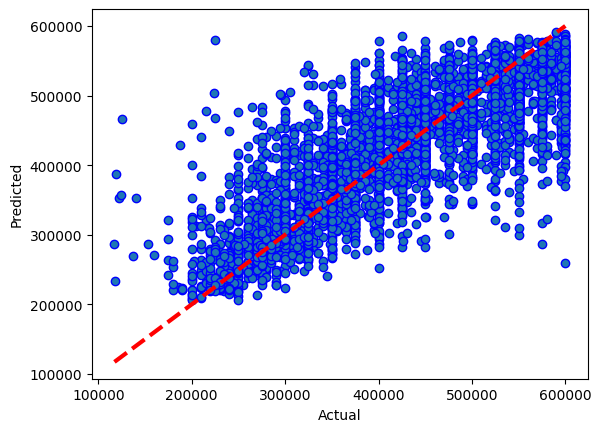

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [55]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now())
}
import json


def update_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)

    results_json[f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()] = results

    with open(results_filename, 'w') as file:
        file.write(json.dumps(results_json, indent=4))


if not IN_COLAB:
    update_results()

results

{'Score': 0.6274698660916171,
 'R square Accuracy': 0.6274698660916171,
 'Mean Absolute Error Accuracy': 49441.22931124543,
 'Mean Squared Error Accuracy': 4262784354.54101,
 'Root Mean Squared Error': 65290.00194931081,
 'Training Time': 0.11113905906677246,
 'random_state': 101,
 'date': '2022-10-12 17:37:11.760678'}